In [1]:
# Notebook to compute, partition, and invert quasigeostrophic potential vorticity
# For MEA 717, spring 2022, Gary Lackmann
# Kudos to Michael Gray for contributing a much faster method of computing Laplacians
#
# This code computes the QG PV vorticity, partitions it, and inverts specified pieces
#
# Some of the following imports are not used right now, but will retain for future flexibility
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pyproj

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
levels_850 = np.arange(1000, 2000, 50)

wnd_levels_850 = np.arange(20, 70, 5) 
levels_250 = np.arange(8200, 9600, 120)
wnd_levels_250 = np.arange(40, 170, 10) 
#levels = np.arange(8200, 9600, 120)
    
############## Create a colormap using ListedColormap #################

#pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)
knots = 1.94384

In [3]:
datafiles = (glob.glob("/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d01_2017-01-09_00:00:00"))
datafiles.sort()
numfiles=len(datafiles)
ncfile = Dataset(datafiles[0])
p = getvar(ncfile, "pressure")
# Get the lat/lon coordinates
wrf_lats, wrf_lons = latlon_coords(p)

## WWRF longitude fix ######
new_lons =np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)

# Sigma for gaussian filter setting for SLP
sigma = 3


In [4]:
# Initialize an empty list to store the filtered ivt arrays
ivt_list = []
slp_list = []
# Get a list of all .npy files in the directory
file_paths = glob.glob('/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_*_20170108_18.npy')
slp_paths = glob.glob('/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850_ht/850mb_ht_*_20170108_18.npy')
# Sort the file paths alphabetically
sorted_file_paths = sorted(file_paths)
# Loop through each file and load, filter, and append the data
for file in sorted_file_paths:
    print(file)
    ivt_arrays = np.load(file, allow_pickle=True)
    #cinvert to knots
    wind = ivt_arrays*knots
    ivt_list.append(wind)
    #print(ivt_arrays.shape)

sorted_slp_paths = sorted(slp_paths)
# Loop through each file and load, filter, and append the data
for file in sorted_slp_paths:
    print(file)
    slp_arrays = np.load(file, allow_pickle=True)
    slp_array = gaussian_filter(slp_arrays, sigma)
    slp_list.append(slp_array)
    #print(ivt_arrays.shape)


/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_ishamel_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_ntu_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_p3_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_p3_2nd_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_p3_2xcloud_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_p3mom_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_thompson_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_thopmson_aa_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_wdm6_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850mb_wind/850mb_wind_wsm6_20170108_18.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/850_ht/850mb_ht_ishamel_20170108_18.npy
/scr

In [5]:
print(len(ivt_list))
# Make a list of title for plotting
titles = ['Ishmael','NTU','P3','P3 2nd', 'P3 2X', 'P3 3-mom',
          'Thompson', 'Thompson AA', 'WDM6', 'WSM6',
           'WWRF Reanalysis']


10


In [7]:

datafiles = glob.glob("/scratch/sawyer/wwrf/2017-01-09/wwrf_6km_reanalysis/wrfcf_d01_2017-01-08_00_00_00.nc")
datafiles.sort()
numfiles=len(datafiles)
print(numfiles)
print(datafiles[0])
# Assuming you only want to inspect the first file

if datafiles:
    nc_file = datafiles[0]
    with Dataset(nc_file, 'r') as nc:
        print("Variables in the .nc file:")
        for variable in nc.variables:
            print(variable)
else:
    print("No files found matching the pattern.")


1
/scratch/sawyer/wwrf/2017-01-09/wwrf_6km_reanalysis/wrfcf_d01_2017-01-08_00_00_00.nc
Variables in the .nc file:
DateTime
IVT
IVTU
IVTV
IWV
Lambert_Conformal
T_2m
T_p
Td_2m
Z_p
Z_sfc
day
forecast_reference_time
hour
lat
lon
minute
month
p_sfc
precip_bkt
pressure
q_2m
q_p
rh_2m
slp
south_north
time
u_10m_tr
u_tr_p
v_10m_tr
v_tr_p
wd_10m
west_east
ws_10m
year


In [7]:
ncfile = Dataset(datafiles[0])
lat =ncfile['lat'][:]
wwrflon = ncfile['lon'][:]
print(lat.shape,wwrflon.shape)
## WWRF longitude fix ######
wwrf_lons =np.where(wwrflon > 0, wwrflon - 360, wwrflon)
u = ncfile['U850'][0]
v = ncfile['V850'][0]
z = ncfile['Z850'][0]
vg_300 = sqrt((u**2)+(v**2)) * knots
print(vg_300.max())

(942,) (1957,)
78.75107


/opt/tljh/user/envs/MEA443/lib/python3.11/site-packages/numpy/ma/core.py:6940: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [8]:
ivt_list.append(vg_300)
slp_list.append(z)

In [9]:
lcc_projection = ccrs.LambertConformal(
    central_longitude=-125.0,
    central_latitude=40.99998,
    standard_parallels=(50, 32))

/tmp/ipykernel_58168/1878797895.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


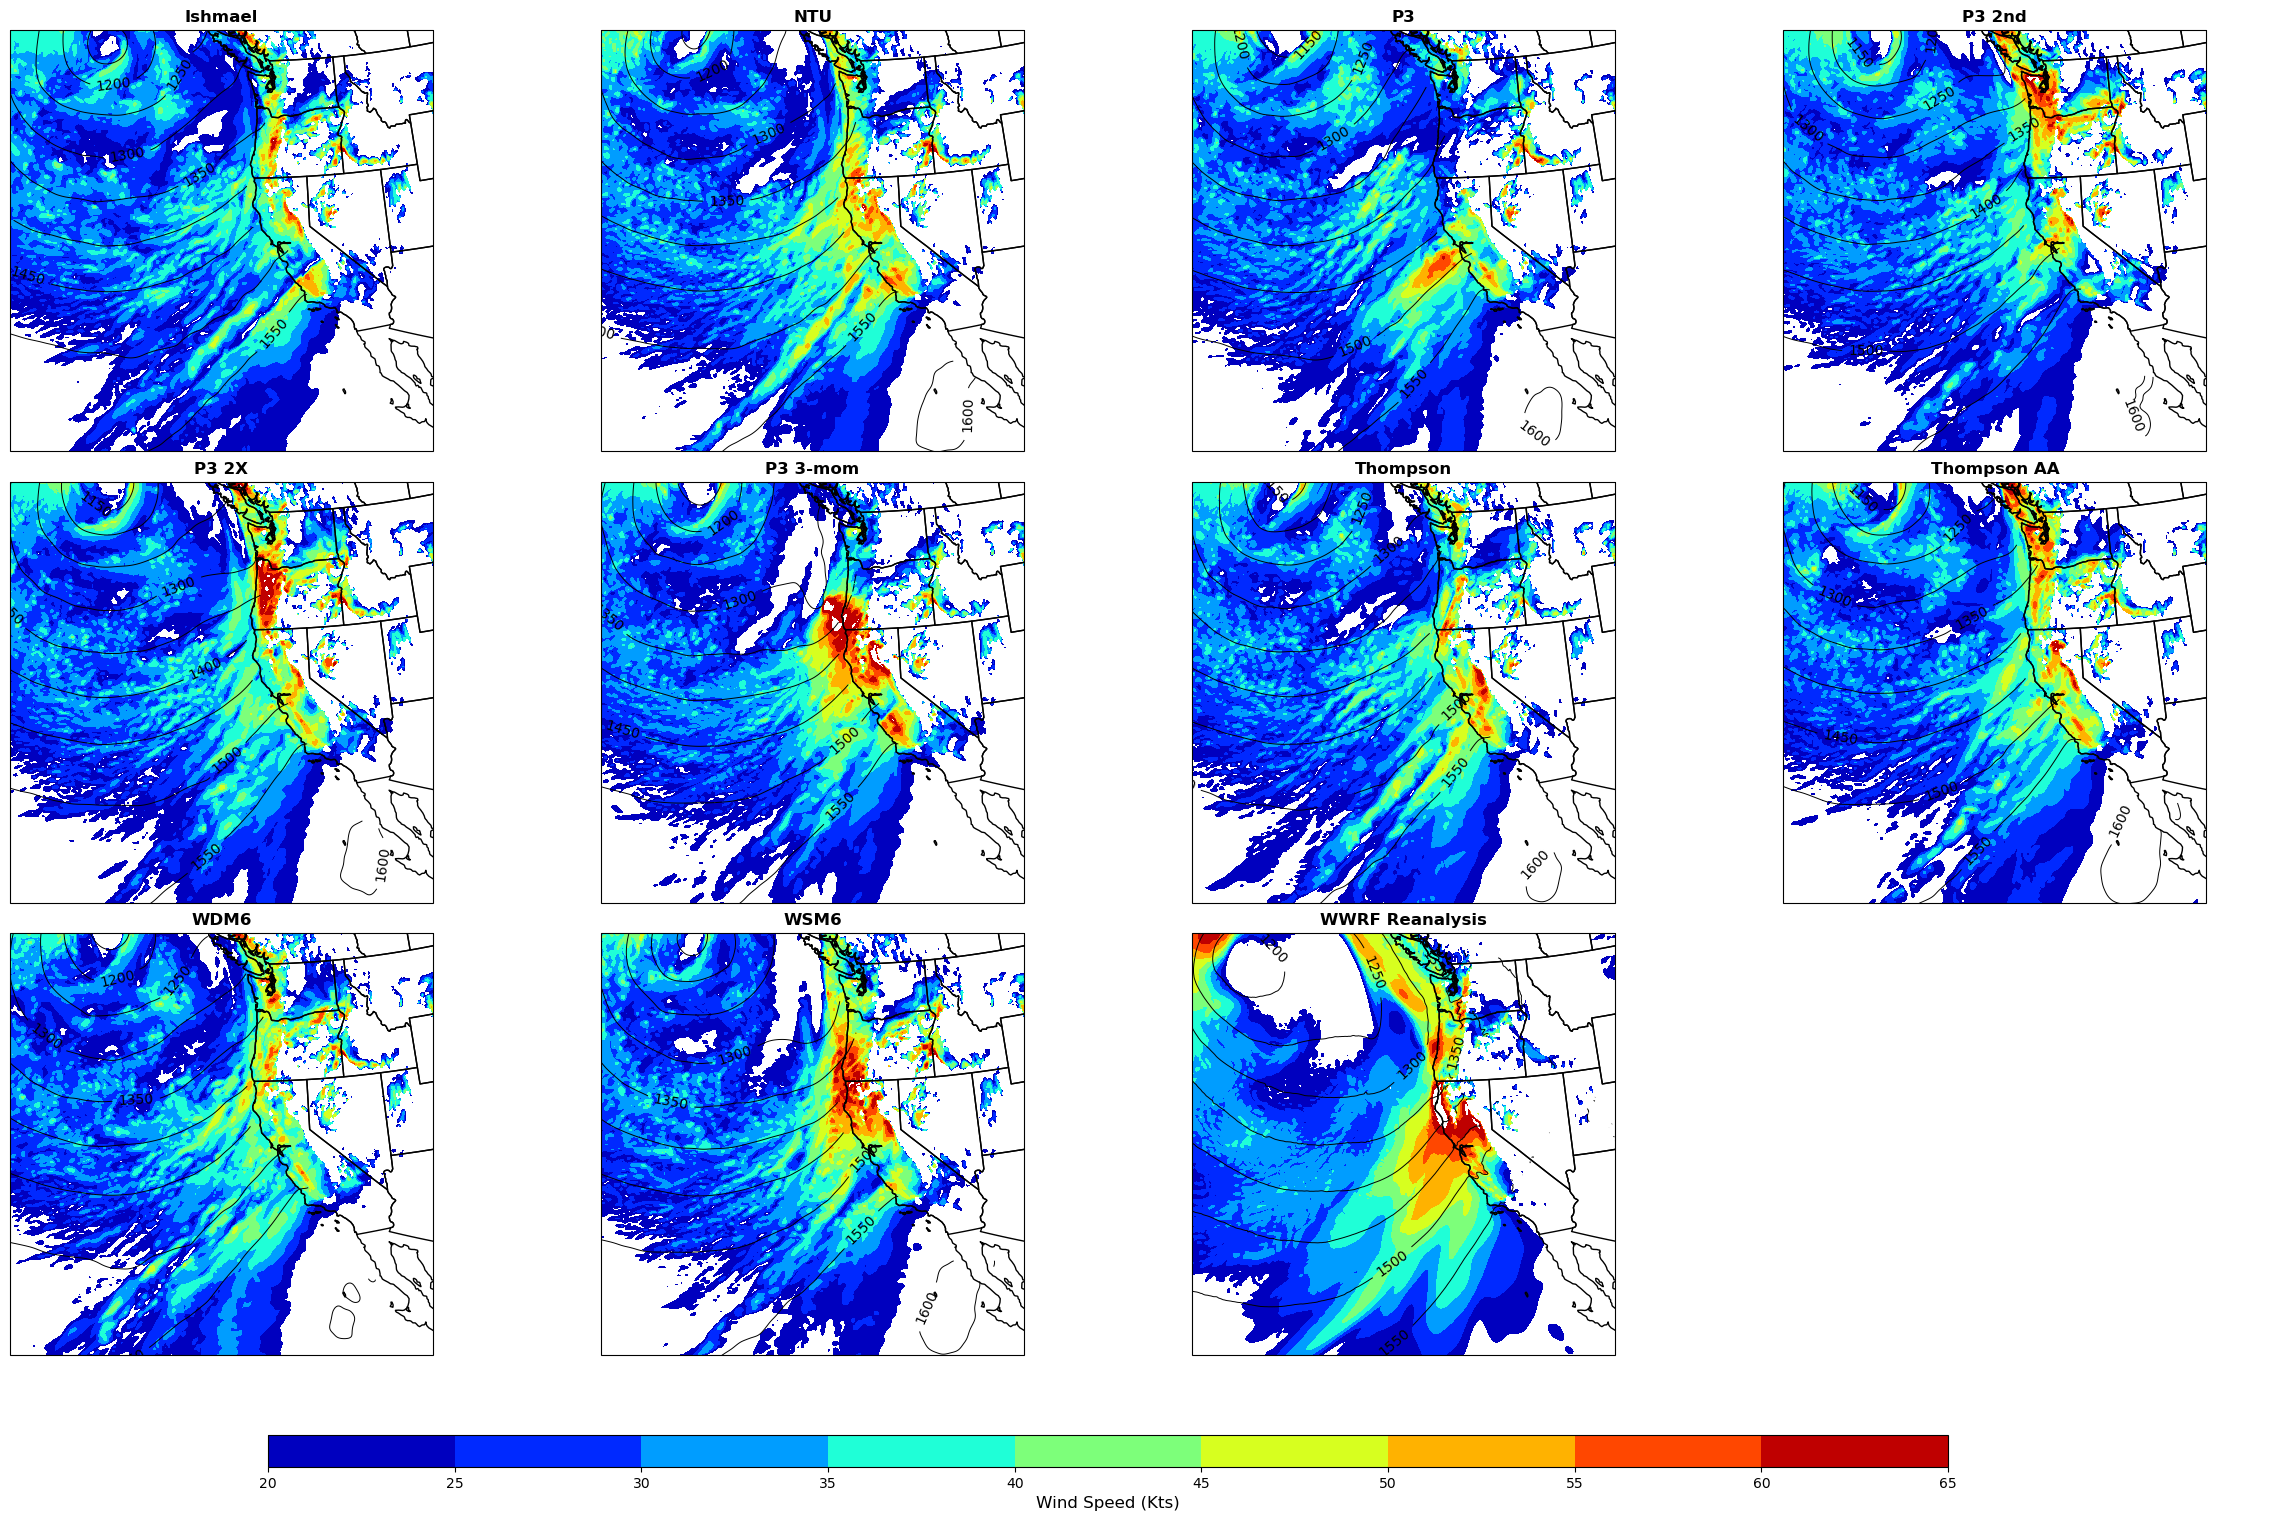

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(24, 16),
                        subplot_kw={'projection': lcc_projection})
axs = axs.ravel()  # Flatten axs

# Loop through the first N-1 elements
for i in range(len(ivt_list)- 1):
    ax = axs[i]
    ax.set_extent([-140, -113, 25, 50])
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black')
    ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor='black')
    ax.set_title(titles[i], fontweight='bold')
    cp = ax.contourf(to_np(new_lons), to_np(wrf_lats), to_np(ivt_list[i]), cmap='jet', 
                     levels=wnd_levels_850, transform=ccrs.PlateCarree())
    cp1 = ax.contour(to_np(new_lons), to_np(wrf_lats), to_np(slp_list[i]),
                         colors = 'black',levels=levels_850, linewidths=.7, alpha=1,transform=crs.PlateCarree())
    ax.clabel(cp1, fmt='%1.0f', inline=True,levels=levels_850)


# Handle the last plot separately
ax = axs[len(ivt_list) - 1]
ax.set_extent([-140, -113, 25, 50])
ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor='black')
ax.set_title(titles[-1], fontweight='bold')
cp = ax.contourf(to_np(wwrf_lons), to_np(lat), to_np(ivt_list[-1]), cmap='jet', 
                 levels=wnd_levels_850, transform=ccrs.PlateCarree())
cp2 = ax.contour(to_np(wwrf_lons), to_np(lat), to_np(slp_list[-1]),
                         colors = 'black',levels=levels_850, linewidths=.7, alpha=1,transform=crs.PlateCarree())
ax.clabel(cp2, fmt='%1.0f', inline=True,levels=levels_850)

# Turn off any remaining subplots
for i in range(len(ivt_list), len(axs)):
    axs[i].axis('off')
# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Wind Speed (Kts)", fontsize = 12)
# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar

plt.savefig('850winds_18z_8Jan')
plt.show()